# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

DATA_FOLDER = '../ADA2017-Tutorials/02 - Intro to Pandas/Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.
PATH_SEPARATOR = '/'

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

The goal here is to go through each folders in the ebola folder and for each one, concatenate all the CSV into a single dataframe.
We need to join the file, but, as we don't have the same column in every files, we need to merge/fills columns from one file to another.
This is exactly what the append method of a DataFrame does, it merges columns and fill empty cell with NaN.

At the end of this operation, we'll be in possession of a single DataFrame for the whole contries.
Another choice we made was to make `date` and `Description`, `Variable`, `variable` column as indexes. This is a detail, but it simplifies the sum over the columns (indexes are not part of columns), and the `.loc` method is more readable when addressing indexes.

The next step was to filter the interessting rows with respect to the labels, as they are different in each contry but can also be different from one file to another we need handles more that one label per country.
Once the rows were fileterd with respect to the labels, we need to sum, for each day all the columns (that represents cities in the country), this is done by keeping only columns that are numbers and add them up.

For each country, we can then return an array of data, representing the number of cases each day.

In [8]:
FOLDER = DATA_FOLDER + PATH_SEPARATOR + "ebola"
COUNTRY_FOLDERS = ['guinea_data', 'sl_data', 'liberia_data']
COUNTRY_INDEXES = [['Description', 'Date'], ['variable', 'date'], ['Variable', 'Date']]
COUNTRY_GROUP = ['Date', 'date', 'Date']
COUNTRY_NEW_CASES_LABELS= [['New cases of confirmed'], ['new_confirmed'], ['New case/s (confirmed)']]
COUNTRY_DEATH_LABELS= [['New deaths registered today (confirmed)', 'New deaths registered'], ['etc_new_deaths'], ['Newly reported deaths']]

def compute(country_folder, indexes=[]):
    country_folder = FOLDER + PATH_SEPARATOR + country_folder
    files = listdir(country_folder)

    dfs = [pd.read_csv(country_folder + PATH_SEPARATOR + file, index_col=indexes) for file in files]
    assert(len(dfs) > 0)
    result = dfs[0].append(dfs[1:])

    return result

In [9]:
def average_per_day(df, group):
    assert(df.empty == False)
    df = df.set_index([group])
    df.index = pd.to_datetime(df.index)
    df = df.apply(pd.to_numeric, errors='ignore')

    grouped = df.groupby(pd.TimeGrouper("m"))

    s = grouped[0].mean()
    s.index = s.index.map(lambda x: x.strftime('%Y-%m'))
    return s

In [10]:
def average_for_label(df, group, labels = []):
    sum = pd.DataFrame()
    for label in labels:
        rows = df.loc[label].apply(pd.to_numeric, errors='ignore')
        filtered = rows.select_dtypes(include=[np.number])
        grouped = filtered.sum(axis=1).groupby(group)
        sum = sum.append(grouped.sum().reset_index(), ignore_index=True) # Sum cities first then group by date
    return average_per_day(sum, group)

In [11]:
result = pd.DataFrame()
for i in range(len(COUNTRY_FOLDERS)):
    df = compute(COUNTRY_FOLDERS[i], COUNTRY_INDEXES[i])
    # There are two ways here, either we remove total and sums the colums, or we could only use total, assuming that it's correctly computed
    if 'Totals' in df.columns.values:
        del df['Totals']
        
    if 'National' in df.columns.values:
        del df['National']
    
    new_cases = average_for_label(df, COUNTRY_GROUP[i], COUNTRY_NEW_CASES_LABELS[i])
    deaths = average_for_label(df, COUNTRY_GROUP[i], COUNTRY_DEATH_LABELS[i])
    labels = new_cases.map(lambda x: COUNTRY_FOLDERS[i].split('_')[0])
    
    result = result.append(pd.concat([new_cases, deaths, labels], axis=1))

result.columns = ['Average number of new cases per days', 'Average number of deaths per day', 'Country']
result




,Average number of new cases per days,Average number of deaths per day,Country
2014-08,12.400000,3.200000,guinea
2014-09,12.562500,3.800000,guinea
2014-10,6.000000,15.000000,guinea
2014-08,19.600000,4.100000,sl
2014-09,36.275862,3.481481,sl
2014-10,57.535714,4.142857,sl
2014-11,69.894737,1.500000,sl
2014-12,54.333333,NaN,sl
2014-06,2.142857,1.857143,liberia
2014-07,1.818182,4.272727,liberia


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [12]:
FOLDER = DATA_FOLDER + PATH_SEPARATOR + "microbiome"
PREFIX = "MID"
NUMBER = 9

header = pd.read_excel(FOLDER + PATH_SEPARATOR + "metadata.xls", sheetname='Sheet1', index_col=0)
final = pd.DataFrame()

for i in range(1, NUMBER+1):
    result = pd.DataFrame()
    result = result.append(pd.read_excel(FOLDER + PATH_SEPARATOR + f"{PREFIX}{i}.xls", sheetname='Sheet 1', header=None))
    result['BARCODE'] = PREFIX + str(i)
    final = final.append(result)

final = final.set_index('BARCODE').join(header).fillna('unknown').reset_index()
#TODO: Uniq index
final


,BARCODE,0,1,GROUP,SAMPLE
0,MID1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,EXTRACTION CONTROL,unknown
1,MID1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,EXTRACTION CONTROL,unknown
2,MID1,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,EXTRACTION CONTROL,unknown
3,MID1,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,EXTRACTION CONTROL,unknown
4,MID1,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,EXTRACTION CONTROL,unknown
5,MID1,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,EXTRACTION CONTROL,unknown
6,MID1,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,EXTRACTION CONTROL,unknown
7,MID1,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,EXTRACTION CONTROL,unknown
8,MID1,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,EXTRACTION CONTROL,unknown
9,MID1,"Archaea ""Euryarchaeota"" Halobacteria Halobacte...",1,EXTRACTION CONTROL,unknown


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [107]:
from IPython.core.display import HTML
df = pd.read_excel(DATA_FOLDER+'/titanic.xls')
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

### 1A. Describe the *type* and the *value range* of each attribute.
Here we display the type of each attribute.

#### Type

In [108]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In a more intuitive way, they can be described as :

pclass | survived | name | sex | age | sibsp | parch | ticket | fare | cabin | embarked | boat | body home.dest
---|---|---|---|---|---|---|---|---|---|---|---|---
natural|boolean|string|category|continuous|natural|natural|string|continuous|string|category|natural|string

#### Range
We only display numerical values, since range makes sense only for them.

In [109]:
df_ranged_types = df.select_dtypes(include=['int64', 'float64'])
df_range['min'] = df_ranged_types.min()
df_range['max'] = df_ranged_types.max()
df_range = df_range[['min', 'max']]
df_range[df_range.notnull().any(axis=1)]

,min,max
pclass,1.0000,3.0000
survived,0.0000,1.0000
age,0.1667,80.0000
sibsp,0.0000,8.0000
parch,0.0000,9.0000
fare,0.0000,512.3292
body,1.0000,328.0000


### 1B. Indicate and transform the attributes that can be `Categorical`. 
We consider to be categorical, attributes that can be use to make groups in the data. They are tipically enumerable. `Categorical` objects are *pclass*, *survived*, *sex*, *cabin*, *embarked* and *boat*.

In [179]:
for col in ['pclass', 'survived', 'sex', 'cabin', 'embarked', 'boat']:
    df[col] = df[col].astype('category')

### 2. Plot histograms
Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals.

In [180]:
def show_column_hist(column_name, data_frame):
    data_frame[column_name].value_counts().plot(kind='bar')
    plt.show()

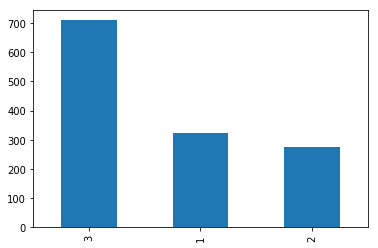

In [181]:
show_column_hist('pclass', df)

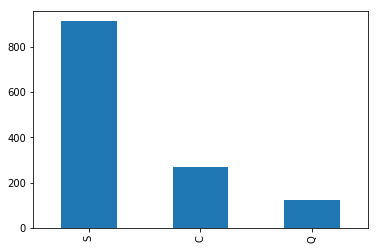

In [182]:
show_column_hist('embarked', df)

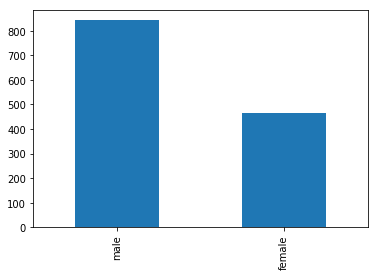

In [183]:
show_column_hist('sex', df)

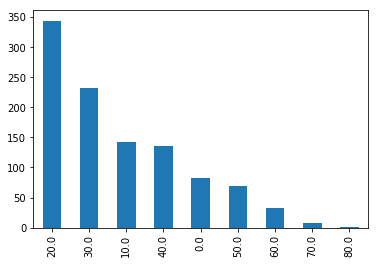

In [184]:
df['age'].apply(lambda x: (x//10)*10).value_counts().plot(kind='bar') # dirty //10 * 10 trick, might be improvable
plt.show()

### 3A. Calculate the proportion of passengers by *cabin floor*.
The first letter of each cabin name in the data indicates the floor to which it pertains. Some people have multiple rooms, but they are always (by inspection) on the same floor. Thus we chose to only keep the first character of the data and make categories out of it. Some cabin numbers have two letters, but we found out that the second one indicates the section.

In [265]:
df_cabin= df[df['cabin'].notnull() & (df['cabin'] != 'T')]['cabin'].astype(str).str[0].to_frame()
cabin_proportions = df_cabin['cabin'].value_counts().apply(lambda x: x / len(df_cabin))
cabin_proportions

C    0.319728
B    0.221088
D    0.156463
E    0.139456
A    0.074830
F    0.071429
G    0.017007
Name: cabin, dtype: float64

 ### 3B. Present your results in a *pie chart*.

In [266]:
def show_pie(serie, title):
    plt.pie(serie, labels=serie.index)
    plt.axis('equal')
    plt.title(title)
    plt.show()

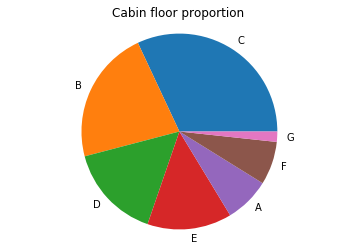

In [267]:
show_pie(cabin_proportions, 'Cabin floor proportion')

### 4A. For each *travel class*, calculate the proportion of the passengers that survived. 

In [309]:
df_travel = df[['pclass', 'survived']]
df_survival_rate = df_travel[df_travel['survived'] == 1].groupby(['pclass']).count() / df_travel.groupby(['pclass']).count()
df_survival_rate

,survived
pclass,
1,0.619195
2,0.429603
3,0.255289


### 4B. Present your results in *pie charts*.

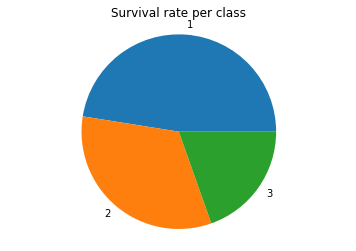

In [304]:
show_pie(df_survival_rate, 'Survival rate per class')

### 5A. Calculate the proportion of the passengers that survived by *travel class* and *sex*. 

In [314]:
df_travel_sex = df[['pclass', 'survived', 'sex']]
df_survival_sex_rate = df_travel_sex[df_travel_sex['survived'] == 1].groupby(['pclass', 'sex']).count() / df_travel_sex.groupby(['pclass', 'sex']).count()
df_survival_sex_rate

survived
pclass sex             
1      female  0.965278
       male    0.340782
2      female  0.886792
       male    0.146199
3      female  0.490741
       male    0.152130

### 5B. Present your results in *a single histogram*.